In [ ]:
!pip install python-dotenv

In [7]:
import os
import pandas as pd
import psycopg2

from dotenv import load_dotenv

load_dotenv()

# Mapeamento pandas → Postgres
pandas_to_postgres = {
    'object': 'TEXT',
    'int64': 'BIGINT',
    'float64': 'DOUBLE PRECISION',
    'bool': 'BOOLEAN',
    'datetime64[ns]': 'TIMESTAMP'
}

# Caminho para os arquivos CSV
CAMINHO_DADOS = "/content/drive/MyDrive/github_projects/data_modeling/dataset"

def ingest_csv(arquivo: str, conn):
    nome_tabela = os.path.splitext(arquivo)[0]
    caminho_arquivo = os.path.join(CAMINHO_DADOS, arquivo)

    df = pd.read_csv(caminho_arquivo)

    # Mapear dtypes
    mapped_dtypes = [
        (col, pandas_to_postgres.get(str(dtype), 'TEXT'))
        for col, dtype in df.dtypes.items()
    ]

    col_defs = ",\n    ".join([f"{col} {pg_type}" for col, pg_type in mapped_dtypes])
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {nome_tabela} (
        {col_defs}
    );
    """

    with conn.cursor() as cur:
        cur.execute(create_table_query)
        conn.commit()
        print(f"Tabela '{nome_tabela}' criada com sucesso.")

        with open(caminho_arquivo, "r") as f:
            next(f)  # pular o cabeçalho
            cur.copy_expert(f"COPY {nome_tabela} FROM STDIN WITH CSV", f)

        conn.commit()
        print(f"Dados carregados em '{nome_tabela}' com sucesso!")
        print("===============================================")


def criar_tabela_postgres(dir_sql_normalizacao: str, conn):
    cur = conn.cursor()
    sql_files = sorted([f for f in os.listdir(dir_sql_normalizacao) if f.endswith(".sql")])

    for sql_file in sql_files:
        caminho = os.path.join(dir_sql_normalizacao, sql_file)
        with open(caminho, "r") as f:
            sql_script = f.read()

        cur.execute(sql_script)
        conn.commit()
        print(f"{sql_file} executado com sucesso!")

def drop_tables(drop_table_file: str, conn):
    cur = conn.cursor()
    with open(drop_table_file, "r") as f:
        sql_script = f.read()

    cur.execute(sql_script)
    conn.commit()
    print("===============================================")
    print(f"Tabelas excluidas com sucesso!")
    print("===============================================")

def main():
    database_url = os.getenv("DATABASE_URL")
    conn = psycopg2.connect(database_url)

    arquivos_csv = [
        arq for arq in os.listdir(CAMINHO_DADOS)
        if arq.endswith(".csv")
    ]

    # Ingestao dos dados
    for arquivo in arquivos_csv:
        ingest_csv(arquivo, conn)

    # Normalizacao
    dir_sql_normalizacao = "/content/drive/MyDrive/github_projects/data_modeling/scripts_sql/normalizacao"
    criar_tabela_postgres(dir_sql_normalizacao, conn)

    drop_table_file = "/content/drive/MyDrive/github_projects/data_modeling/scripts_sql/drop_csv_tables.sql"
    drop_tables(drop_table_file, conn)

    print("Processo concluído com sucesso!")
    conn.close()

if __name__ == "__main__":
    main()


Tabela 'olist_customers_dataset' criada com sucesso.
Dados carregados em 'olist_customers_dataset' com sucesso!
Tabela 'olist_order_items_dataset' criada com sucesso.
Dados carregados em 'olist_order_items_dataset' com sucesso!
Tabela 'olist_order_payments_dataset' criada com sucesso.
Dados carregados em 'olist_order_payments_dataset' com sucesso!
Tabela 'olist_order_reviews_dataset' criada com sucesso.
Dados carregados em 'olist_order_reviews_dataset' com sucesso!
Tabela 'olist_orders_dataset' criada com sucesso.
Dados carregados em 'olist_orders_dataset' com sucesso!
Tabela 'olist_products_dataset' criada com sucesso.
Dados carregados em 'olist_products_dataset' com sucesso!
Tabela 'olist_sellers_dataset' criada com sucesso.
Dados carregados em 'olist_sellers_dataset' com sucesso!
Tabela 'product_category_name_translation' criada com sucesso.
Dados carregados em 'product_category_name_translation' com sucesso!
Tabela 'olist_geolocation_dataset_part1' criada com sucesso.
Dados carrega

In [8]:
conn = psycopg2.connect(database_url)
cur = conn.cursor()

cur.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
    AND table_type = 'BASE TABLE';
""")

tabelas = cur.fetchall()
for tabela in tabelas:
    print(tabela[0])

cur.close()
conn.close()

categorias_produto
clientes
geolocalizacao
itens_pedido
pagamentos
pedidos
produtos
reviews_table
vendedores


In [ ]:
def criar_tabela_postgres(dir_sql_normalizacao: str, conn):
    cur = conn.cursor()
    sql_files = sorted([f for f in os.listdir(dir_sql_normalizacao) if f.endswith(".sql")])

    for sql_file in sql_files:
        caminho = os.path.join(dir_sql_normalizacao, sql_file)
        with open(caminho, "r") as f:
            sql_script = f.read()

        cur.execute(sql_script)
        conn.commit()
        print(f"{sql_file} executado com sucesso!")

    cur.close()

# Uso

conn = psycopg2.connect(database_url)
dir_sql_normalizacao = "/content/drive/MyDrive/github_projects/data_modeling/scripts_sql/normalizacao"
criar_tabela_postgres(dir_sql_normalizacao, conn)

conn.close()

In [16]:
def drop_all_tables(conn, schema='public'):
    with conn.cursor() as cur:
        cur.execute(f"""
            SELECT table_name
            FROM information_schema.tables
            WHERE table_schema = %s
              AND table_type = 'BASE TABLE';
        """, (schema,))

        tabelas = cur.fetchall()
        for (tabela,) in tabelas:
            cur.execute(f'DROP TABLE IF EXISTS "{schema}"."{tabela}" CASCADE;')
            print(f'Tabela {tabela} deletada.')
        conn.commit()

# Exemplo de uso

conn = psycopg2.connect(database_url)
drop_all_tables(conn)
conn.close()

In [15]:

conn = psycopg2.connect(database_url)
cur = conn.cursor()

cur.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
    AND table_type = 'BASE TABLE';
""")

tabelas = cur.fetchall()
for tabela in tabelas:
    print(tabela[0])

cur.close()
conn.close()

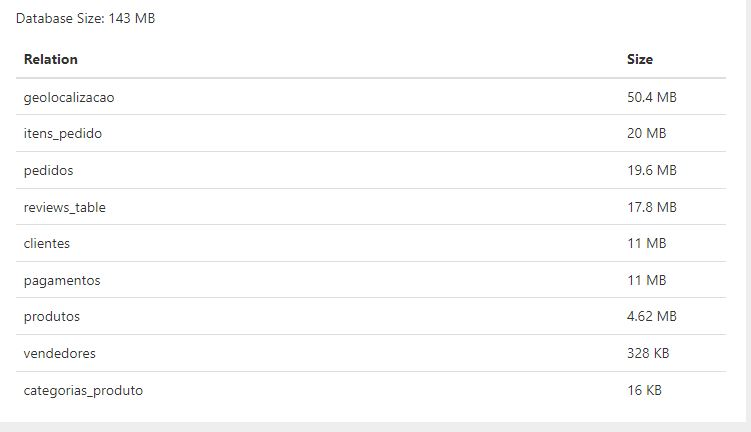

In [13]:

conn = psycopg2.connect(database_url)

query = ("""
SELECT
    p.order_id,
    c.customer_unique_id,
    c.customer_city,
    c.customer_state,
    pr.product_category_name,
    v.seller_city,
    v.seller_state,
    i.price,
    i.freight_value,
    pg.payment_type,
    pg.payment_value,
    r.review_score,
    r.review_creation_date
FROM pedidos p
JOIN clientes c ON p.customer_id = c.customer_id
JOIN itens_pedido i ON p.order_id = i.order_id
JOIN produtos pr ON i.product_id = pr.product_id
JOIN vendedores v ON i.seller_id = v.seller_id
JOIN pagamentos pg ON p.order_id = pg.order_id
LEFT JOIN reviews_table r ON p.order_id = r.order_id
LIMIT 100;
""")

df = pd.read_sql(query, conn)

display(df.head())
conn.close()


<ipython-input-13-9a306ffa6cf5>:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,order_id,customer_unique_id,customer_city,customer_state,product_category_name,seller_city,seller_state,price,freight_value,payment_type,payment_value,review_score,review_creation_date
0,03ef5dedbe7492bdae72eec50764c43f,b701bebbdf478f5500348f03aff62121,sao caetano do sul,SP,artigos_de_festas,sao paulo,SP,24.90,8.33,credit_card,33.23,3,2018-08-31 00:00:00
1,0fd408210166f23fe823070a2f690048,fb6fb9d0e2c0e57e35db552606a2e7e8,itatiba,SP,cool_stuff,belo horizonte,MG,29.99,15.23,credit_card,135.66,1,2018-03-15 00:00:00
2,17abba481cb8e119c2d2fe55ee7e6bee,e412dc0d60c3d444579c73a576d45b12,sao paulo,SP,bebes,mirandopolis,SP,189.90,19.63,credit_card,209.53,5,2018-08-09 00:00:00
3,0409a79770433fbb5610660b8f8cd69d,5cb9d38e39626a98106af8b691fac4fb,camacari,BA,moveis_decoracao,monte siao,MG,38.50,17.92,credit_card,112.84,4,2017-06-30 00:00:00
4,0ac645ddb846d1373321decb39c9956f,969cdc8af5b07074766e79c1e6d76c24,sao paulo,SP,eletroportateis,caxias do sul,RS,49.10,18.23,credit_card,134.66,4,2018-05-12 00:00:00
